In [2]:
__author__ = 'Anastasia Tsvetkova'
__email__  = 'tsvetkova.lea@gmail.com'

%matplotlib notebook
import matplotlib.pyplot as plt
import os, glob, yaml, re
import pandas as pd
from twopc import compute_ppc
from tqdm.auto import tqdm 

import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

In [3]:
from threeML import *
from threeML.io.package_data import get_path_of_data_file

In [4]:
"""
Getting Swift long trigger names
"""

bat_trig = dict()

with open(f'./BAT_summary_general.txt', 'r') as f:
    next(f)
    for line in f:
        GRBname, Trig_ID, Trig_time_met, Trig_time_UTC, RA_ground, DEC_ground, Image_position_err, Image_SNR, \
        T90, T90_err, T50, T50_err, Evt_start_sincetrig, Evt_stop_sincetrig, pcode, Trigger_method, \
        XRT_detection, comment = re.split(r'\s+\|\s+', line)
        if re.search('\D+', Trig_ID): continue

        GRBname = GRBname.replace('GRB', '')

        if len(Trig_ID) == 6: Trig_ID += '000'
        elif len(Trig_ID) < 6: print('GRB', GRBname, Trig_ID, 'is too short!')

        bat_trig[GRBname] = '{:011d}'.format(int(Trig_ID))

 WARNING  |  Found TSTOP and TELAPSE. This file is invalid. Using TSTOP. 
 WARNING  |  FILTER is not set. This is not a compliant OGIP file. Assuming no FILTER. 
 WARNING  |  The default choice for MATRIX extension failed:KeyError("Extension ('MATRIX', 1) not found.")available: None 'EBOUNDS' 'SPECRESP MATRIX' 
 WARNING  |  Minimum MC energy (10.0) is larger than minimum EBOUNDS energy (0.0) 
 INFO     |  Auto-probed noise models: 
 INFO     |  - observation: gaussian 
 INFO     |  - background: None 
 INFO     |  Range 15-150 translates to channels 3-62 


<IPython.core.display.Javascript object>


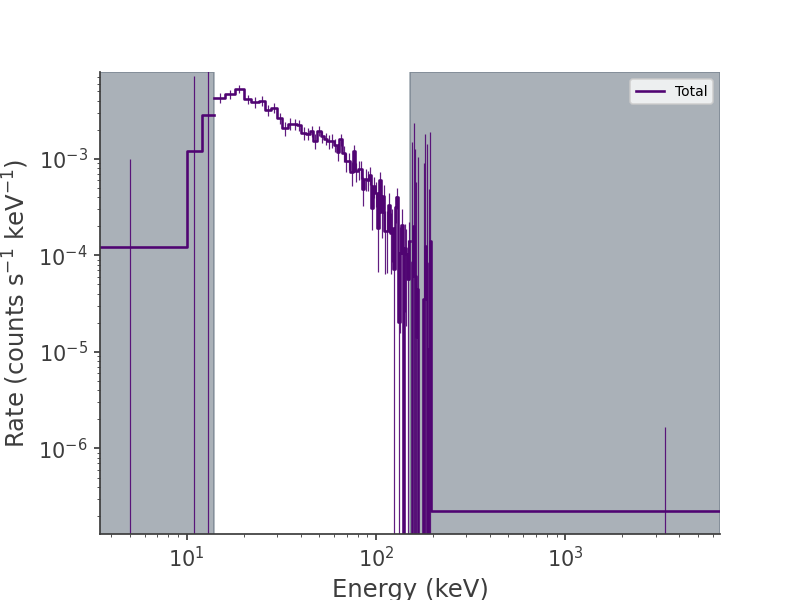

In [5]:
name = '080714'
sp_id = '1_6'

"""
Loading the BAT data
"""

path2BATdata = f"./{name}/BAT_spectra/"

bat_pha_file = path2BATdata + f"BAT_{bat_trig[name]}_sp{sp_id}.pha"
bat_rsp_file = path2BATdata + f"BAT_{bat_trig[name]}_sp{sp_id}_averaged.rmf"

bat = OGIPLike("bat", observation=bat_pha_file, response=bat_rsp_file)

bat.set_active_measurements("15-150")
fig = bat.view_count_spectrum()
# # Saving count spectrum to file
# fig.savefig(f"./{name}/{name}_sp{sp_id}_bat.pdf")

In [6]:
# Making a list of spectra
data_list = DataList(bat)

## Bayesian approach

In [7]:
'''
Setting priors for the model
'''

band = Band()

band.alpha.prior = Truncated_gaussian(lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5)
band.beta.prior = Truncated_gaussian(lower_bound=-5, upper_bound=-1.6, mu=-2.25, sigma=0.5)
band.xp.prior = Log_normal(mu=2, sigma=1)
band.xp.bounds = (0, None)
band.K.prior = Log_uniform_prior(lower_bound=1e-6, upper_bound=1e1)
ps = PointSource("band_bayes", 0, 0, spectral_shape=band)
model = Model(ps)

In [8]:
'''
Passing the model and the data list of the plugins to a BayesianAnalysis class and 
setting the sampler
'''

# set up the sampler and fit
bayes = BayesianAnalysis(model, data_list)

In [9]:
bayes.set_sampler("multinest")
bayes.sampler.setup(n_live_points=400)
bayes.sample()

 INFO     |  Sampler set to multinest 
  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
band_bayes.spectrum.main.Band.K,(1.3 -0.8 -0.4) x 10^-2,1 / (cm2 keV s)
band_bayes.spectrum.main.Band.alpha,-1.20 -0.13 +0.12,
band_bayes.spectrum.main.Band.xp,(1.6 -0.5 +0.6) x 10^2,keV
band_bayes.spectrum.main.Band.beta,-2.3 -0.5 +0.6,



Values of -log(posterior) at the minimum:



,-log(posterior)
bat,-30.379752
total,-30.379752



Values of statistical measures:



,statistical measures
AIC,69.486777
BIC,77.136883
DIC,-1688.641507
PDIC,-1752.896167
log(Z),-17.788410


 WARNING  |  get_point_source_flux() has been replaced by get_flux() 


Propagating errors:   0%|          | 0/1 [00:00<?, ?it/s]

,flux
band_bayes: total,(3.0 -1.3 +5) x 10^-7 erg / (cm2 s)


Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


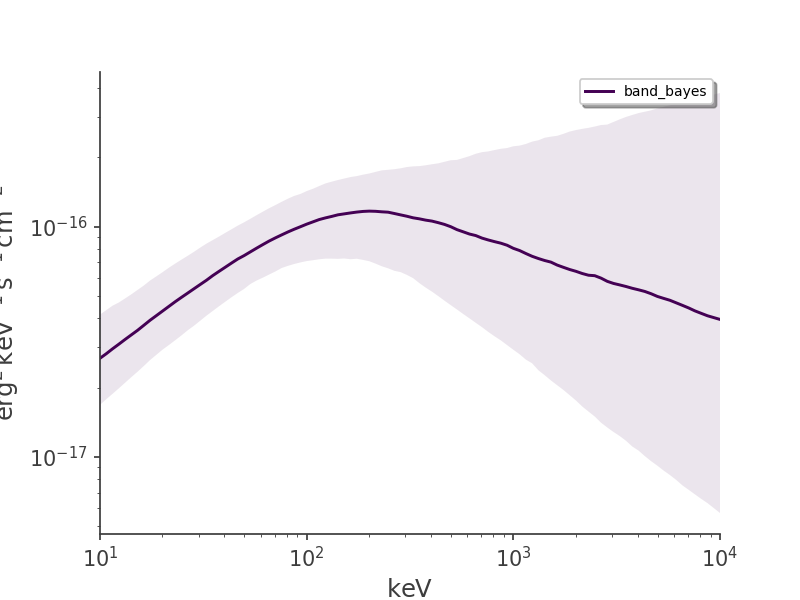

In [10]:
# Let's examine how well the model fit matches the data

bayes.restore_median_fit()
# _ = display_spectrum_model_counts(bayes, min_rate=20, step=False)

# Getting energy flux in 20 keV-10 MeV energy range
flux = bayes.results.get_point_source_flux(20 * u.keV, 10 * u.MeV)

# # Saving energy flux to file
# flux.to_csv(f"./{name}/flux_bayes.txt", sep='\t', float_format='%.3f')
    
# Finally, we can plot the models together to see how the spectra evolve with time.
fig = plot_spectra(bayes.results, flux_unit="erg2/(cm2 s keV)", fit_cmap='viridis', contour_cmap='viridis', contour_style_kwargs=dict(alpha=0.1));

# # Saving the figure to file
# fig.savefig(f"./{name}/unfolded_fit_bayes.pdf")


In [11]:
ar = bayes.results
ar.display()

# # Saving analysis results to file
# ar.write_to(f"./{name}/fit_bayes.fits", overwrite=True)

Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
band_bayes.spectrum.main.Band.K,(1.3 -0.8 -0.4) x 10^-2,1 / (cm2 keV s)
band_bayes.spectrum.main.Band.alpha,-1.20 -0.13 +0.12,
band_bayes.spectrum.main.Band.xp,(1.6 -0.5 +0.6) x 10^2,keV
band_bayes.spectrum.main.Band.beta,-2.3 -0.5 +0.6,



Values of -log(posterior) at the minimum:



,-log(posterior)
bat,-30.379752
total,-30.379752



Values of statistical measures:



,statistical measures
AIC,69.486777
BIC,77.136883
DIC,-1688.641507
PDIC,-1752.896167
log(Z),-17.788410


In [12]:
ar_opt = ar.optimized_model

# # Saving analysis results for the optimized model to file
# with open(f"./{name}/fit_bayes.txt", 'w') as f:
#     for i in ar_opt:
#         print(i, file=f)

In [13]:
ar.display()

Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
band_bayes.spectrum.main.Band.K,(1.3 -0.8 -0.4) x 10^-2,1 / (cm2 keV s)
band_bayes.spectrum.main.Band.alpha,-1.20 -0.13 +0.12,
band_bayes.spectrum.main.Band.xp,(1.6 -0.5 +0.6) x 10^2,keV
band_bayes.spectrum.main.Band.beta,-2.3 -0.5 +0.6,



Values of -log(posterior) at the minimum:



,-log(posterior)
bat,-30.379752
total,-30.379752



Values of statistical measures:



,statistical measures
AIC,69.486777
BIC,77.136883
DIC,-1688.641507
PDIC,-1752.896167
log(Z),-17.788410


In [14]:
data = ar.get_data_frame()
data

,value,negative_error,positive_error,error,unit
band_bayes.spectrum.main.Band.K,0.013255,-0.007812,-0.004429,0.001691,1 / (cm2 keV s)
band_bayes.spectrum.main.Band.alpha,-1.198071,-0.128393,0.120298,0.124345,
band_bayes.spectrum.main.Band.xp,155.246048,-50.061618,61.378710,55.720164,keV
band_bayes.spectrum.main.Band.beta,-2.277405,-0.462757,0.585946,0.524351,


<IPython.core.display.Javascript object>


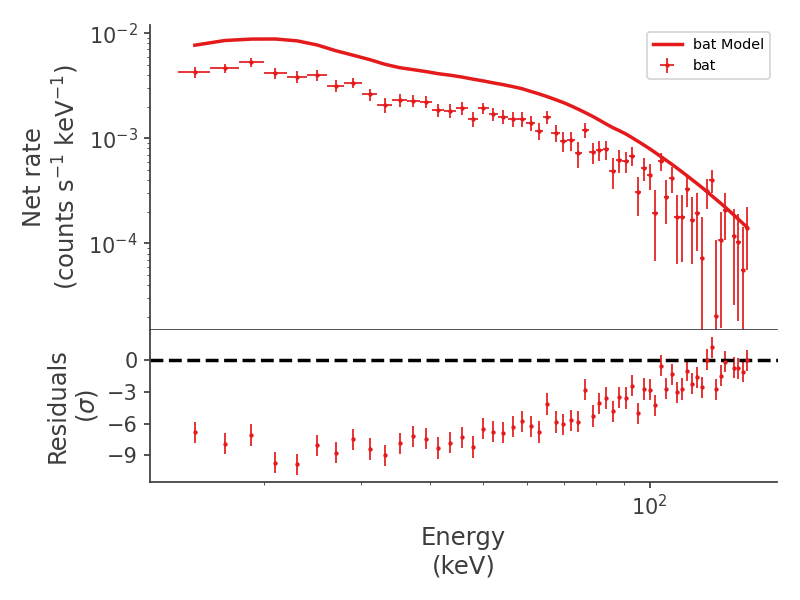

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


In [15]:
# Plotting the fit
fig = display_spectrum_model_counts(bayes, step=False)
# # Saving the figure to file
# fig.savefig("./"+f"{name}_sp{sp_id}_fit_bayes.pdf")


In [16]:
ar.get_data_frame()

,value,negative_error,positive_error,error,unit
band_bayes.spectrum.main.Band.K,0.013255,-0.007812,-0.004429,0.001691,1 / (cm2 keV s)
band_bayes.spectrum.main.Band.alpha,-1.198071,-0.128393,0.120298,0.124345,
band_bayes.spectrum.main.Band.xp,155.246048,-50.061618,61.378710,55.720164,keV
band_bayes.spectrum.main.Band.beta,-2.277405,-0.462757,0.585946,0.524351,


#### I've adjusted manually the value of K (during the previous run of this notebook)

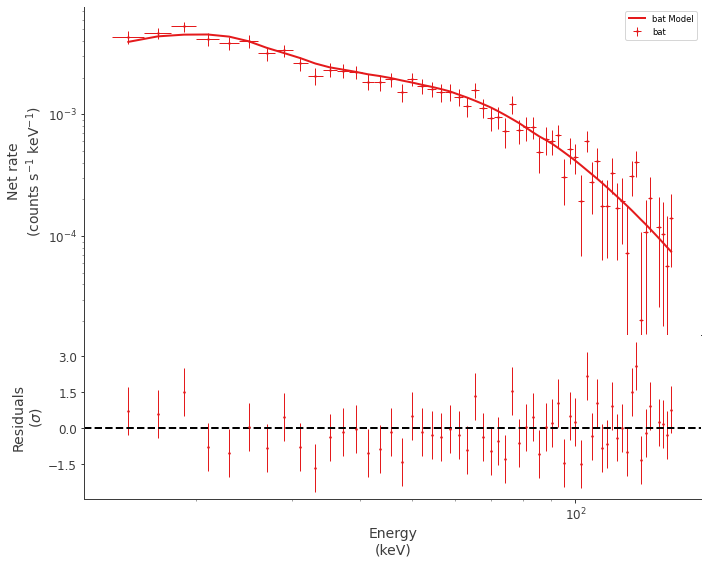

In [35]:
# band.K.value = 7e-3

# # Plotting the fit
# fig = display_spectrum_model_counts(bayes, step=False)
# # Saving the figure to file
# fig.savefig(f"./{name}/fit_bayes_K.pdf")

<IPython.core.display.Javascript object>


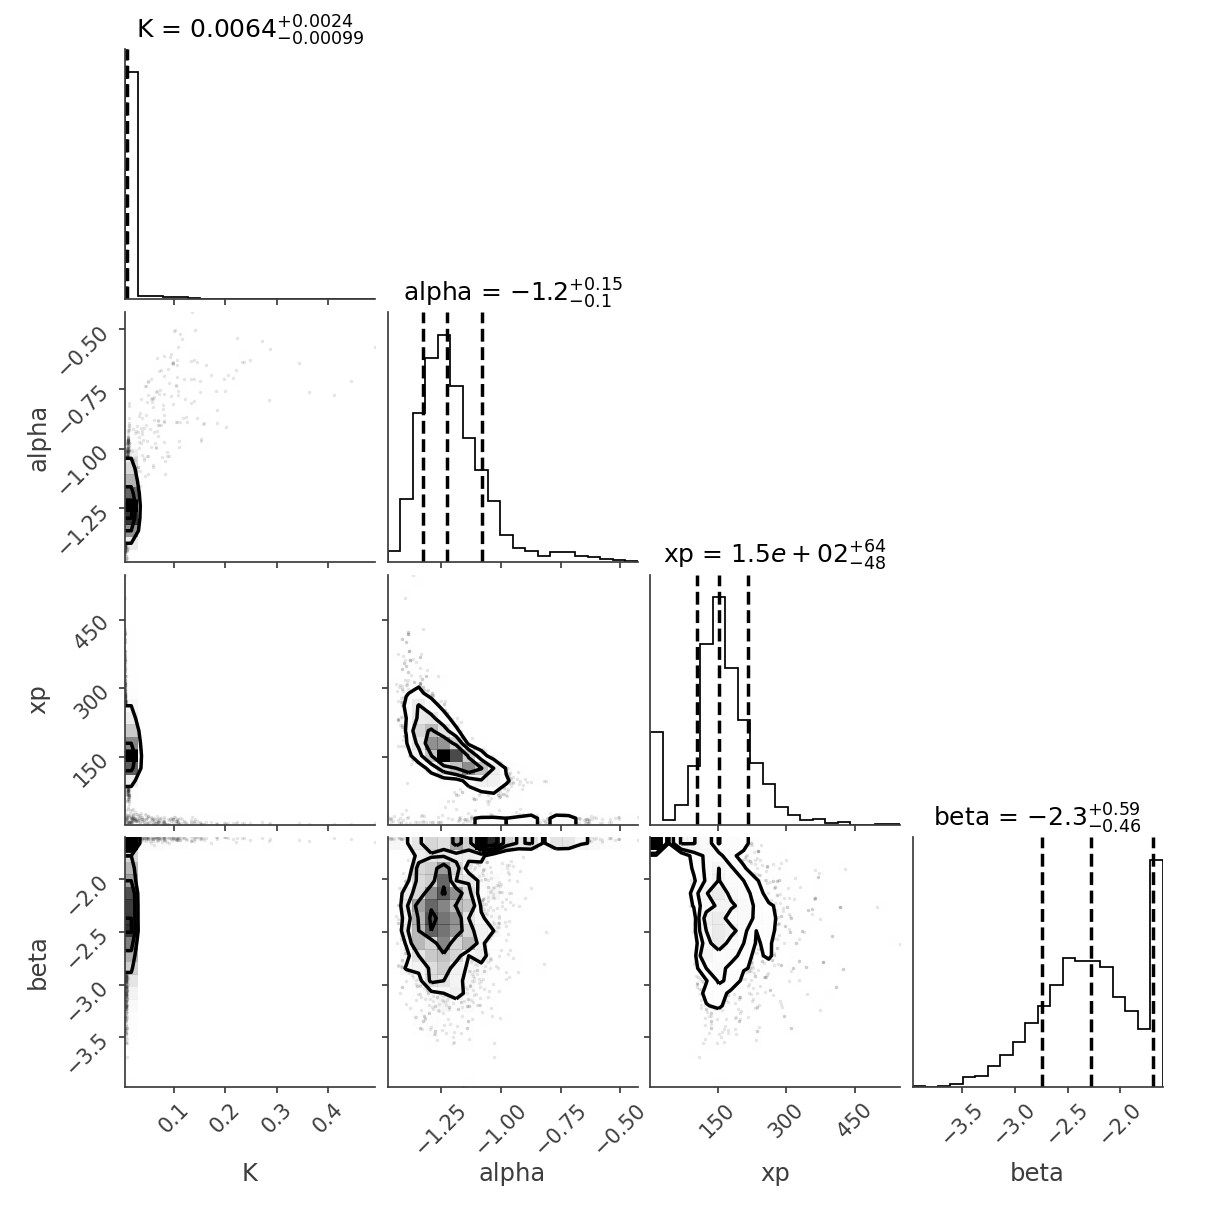

In [17]:
# Making corner plots
fig = ar.corner_plot()

# # Saving the figure to file
# fig.savefig(f"./{name}_sp{sp_id}_fit_corner_plot.pdf")

#### Here the K paramater has already changed to the right value

<IPython.core.display.Javascript object>


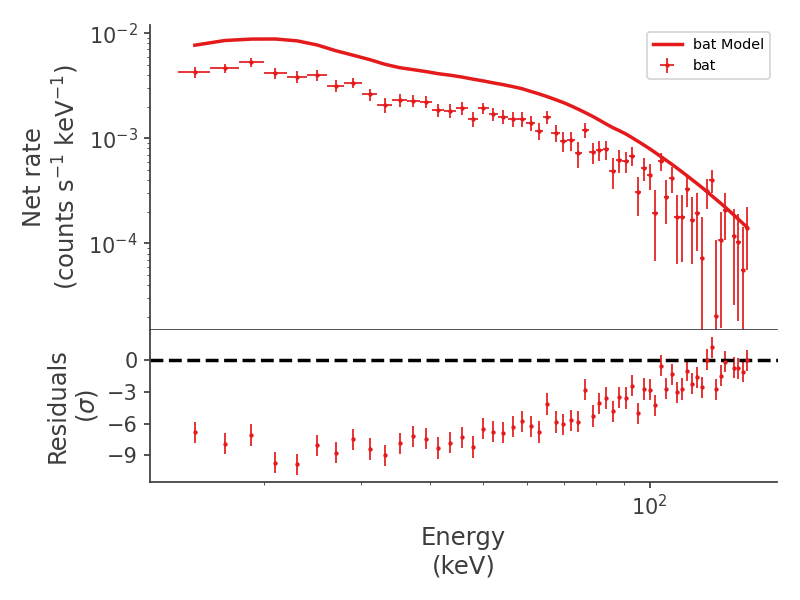

In [18]:
fig = display_spectrum_model_counts(bayes, step=False)


#### However, the plot of the spectral fit has incorrect value of K

In [20]:
ppc = compute_ppc(bayes, bayes.results, n_sims=1000, file_name="bayes_ppc.h5", overwrite=True, return_ppc=True)


sampling posterior:   0%|          | 0/1000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


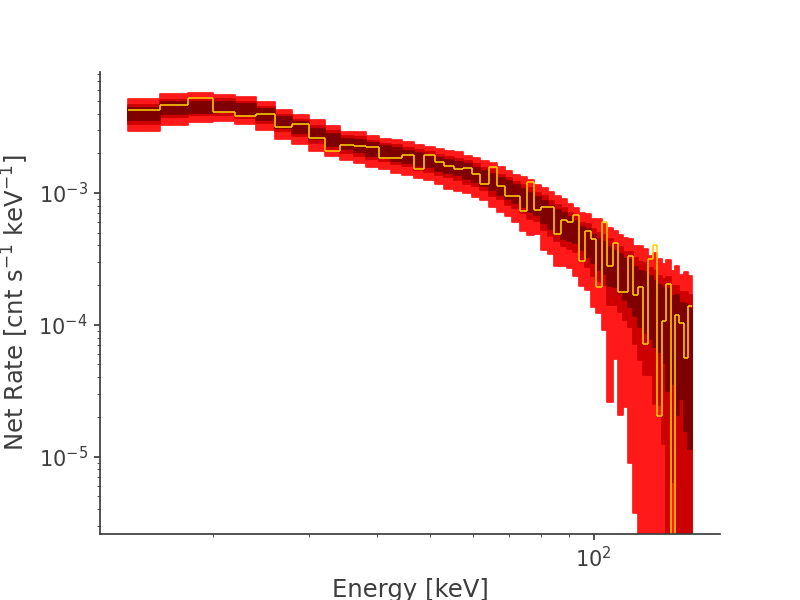

In [21]:
fig = ppc._det_list['bat'].plot(bkg_subtract=True, colors=['#FF1919', '#CC0000', '#7F0000'])

<IPython.core.display.Javascript object>


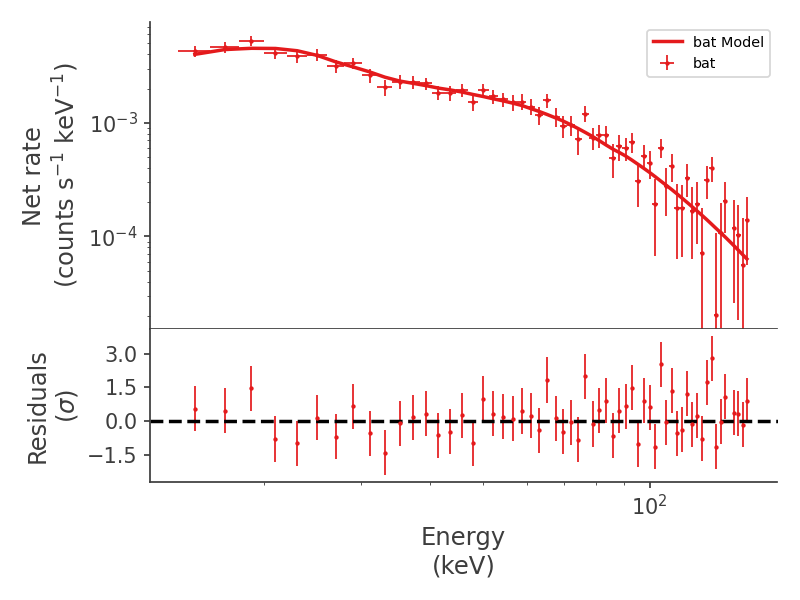

In [22]:
fig = display_spectrum_model_counts(bayes, step=False)

#### 3ML has adjusted the value of K